In [6]:
from matplotlib import pyplot as plot

# Dane z sezonowością (sprzedaż kwartalna)
# Q1 (niska), Q2 (średnia), Q3 (wysoka), Q4 (najwyższa)
sales = [30, 45, 80, 100,  # Rok 1
         35, 50, 85, 105,  # Rok 2
         40, 55, 90, 110,  # Rok 3
         45, 60, 95, 115]  # Rok 4

seasonal_period = 4  # Długość sezonu

In [7]:
def holt_winters_additive(data, season_length, alpha=0.2, beta=0.1, gamma=0.3):
    """
    Metoda Holt-Winters (Potrójne Wygładzanie Wykładnicze)
    Model addytywny: F_t = (L_t + T_t) + S_t
    
    alpha: wygładzanie poziomu
    beta: wygładzanie trendu
    gamma: wygładzanie sezonowości
    """
    if len(data) < 2 * season_length:
        raise ValueError(f"Potrzeba min. {2 * season_length} obserwacji")
    
    # Inicjalizacja
    level = [sum(data[:season_length]) / season_length]
    
    first_avg = sum(data[:season_length]) / season_length
    second_avg = sum(data[season_length:2*season_length]) / season_length
    trend = [(second_avg - first_avg) / season_length]
    
    seasonal = [data[i] - level[0] for i in range(season_length)]
    smoothed = [level[0] + seasonal[0]]
    
    # Wygładzanie
    for t in range(1, len(data)):
        old_level = level[-1]
        old_trend = trend[-1]
        old_seasonal = seasonal[t % season_length]
        
        # Aktualizacja poziomu: L_t = α * (X_t - S_{t-m}) + (1-α) * (L_{t-1} + T_{t-1})
        new_level = alpha * (data[t] - old_seasonal) + (1 - alpha) * (old_level + old_trend)
        
        # Aktualizacja trendu: T_t = β * (L_t - L_{t-1}) + (1-β) * T_{t-1}
        new_trend = beta * (new_level - old_level) + (1 - beta) * old_trend
        
        # Aktualizacja sezonowości: S_t = γ * (X_t - L_t) + (1-γ) * S_{t-m}
        new_seasonal = gamma * (data[t] - new_level) + (1 - gamma) * old_seasonal
        
        # Wartość wygładzona: F_t = L_t + S_t
        new_smoothed = new_level + new_seasonal
        
        level.append(new_level)
        trend.append(new_trend)
        seasonal[t % season_length] = new_seasonal
        smoothed.append(new_smoothed)
    
    return smoothed, level, trend, seasonal


def holt_winters_forecast(level, trend, seasonal, season_length, periods=4):
    """
    Prognozowanie: F_{t+h} = L_t + h * T_t + S_{t+h-m}
    """
    prognozy = []
    for h in range(1, periods + 1):
        season_idx = (len(level) - 1 + h) % season_length
        prognoza = level[-1] + h * trend[-1] + seasonal[season_idx]
        prognozy.append(prognoza)
    return prognozy


# Zastosowanie
alpha, beta, gamma = 0.2, 0.1, 0.3

smoothed, levels, trends, seasonals = holt_winters_additive(
    sales, seasonal_period, alpha, beta, gamma
)

forecasts = holt_winters_forecast(levels, trends, seasonals, seasonal_period, periods=4)

print("Dane oryginalne: ", sales)
print("Dane wygładzone: ", [round(x, 2) for x in smoothed])
print(f"\nPoziom końcowy: {levels[-1]:.2f}")
print(f"Trend końcowy: {trends[-1]:.3f}")
print(f"Sezonowość: {[round(s, 2) for s in seasonals]}")
print(f"\nPrognozy: {[round(x, 2) for x in forecasts]}")

Dane oryginalne:  [30, 45, 80, 100, 35, 50, 85, 105, 40, 55, 90, 110, 45, 60, 95, 115]
Dane wygładzone:  [30.0, 45.7, 81.25, 101.66, 34.15, 49.8, 85.36, 105.83, 39.09, 54.59, 90.06, 110.49, 44.25, 59.61, 94.97, 115.33]

Poziom końcowy: 80.49
Trend końcowy: 1.174
Sezonowość: [-32.67, -18.62, 15.55, 34.83]

Prognozy: [48.99, 64.22, 99.56, 120.02]


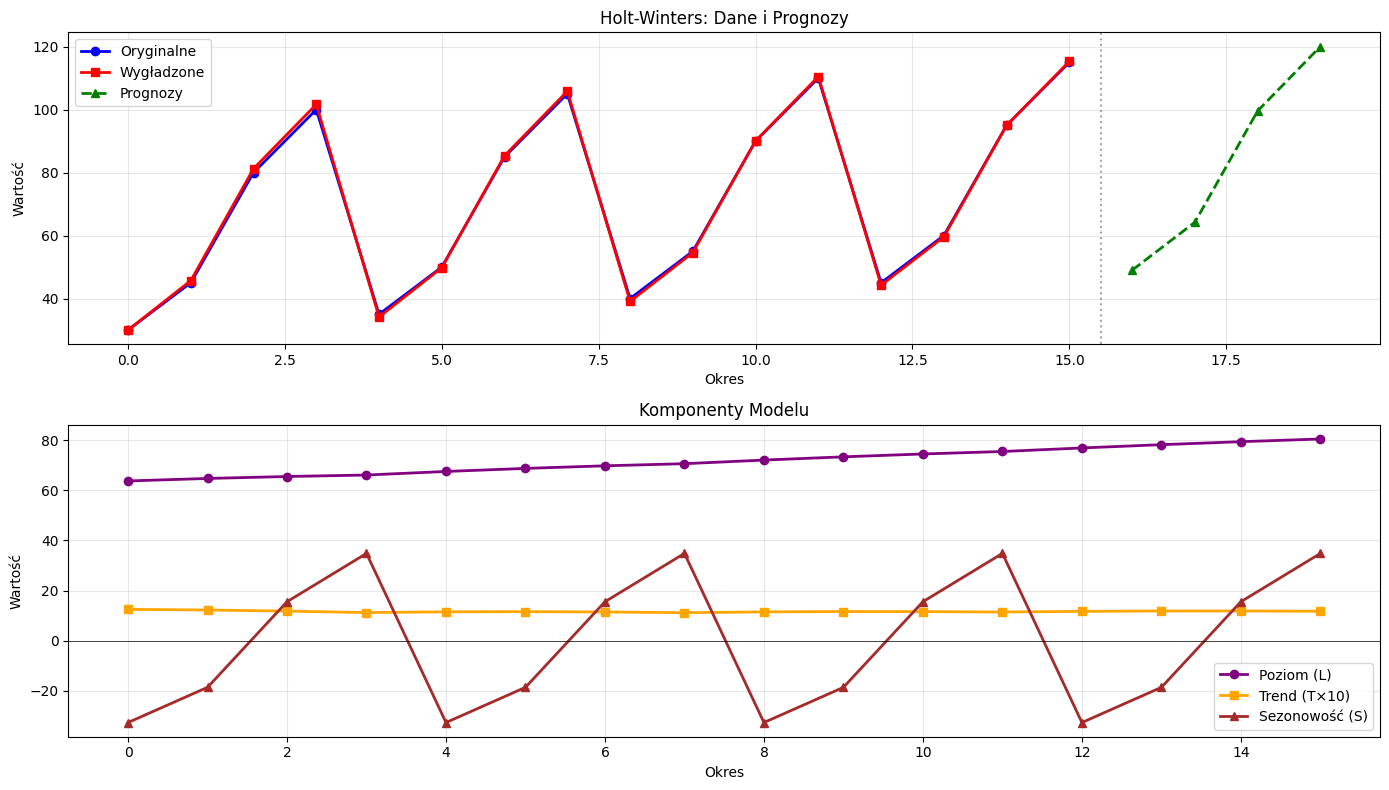

In [8]:
# Wizualizacja
figure = plot.figure(figsize=(14, 8))

# Wykres 1: Dane i prognozy
plot.subplot(2, 1, 1)
plot.plot(sales, label='Oryginalne', marker='o', color='blue', linewidth=2)
plot.plot(smoothed, label='Wygładzone', marker='s', color='red', linewidth=2)
plot.plot(range(len(sales), len(sales) + len(forecasts)), forecasts, 
          label='Prognozy', marker='^', linestyle='--', color='green', linewidth=2)
plot.axvline(x=len(sales)-0.5, color='gray', linestyle=':', alpha=0.7)
plot.title("Holt-Winters: Dane i Prognozy")
plot.xlabel("Okres")
plot.ylabel("Wartość")
plot.legend()
plot.grid(True, alpha=0.3)

# Wykres 2: Komponenty
plot.subplot(2, 1, 2)
plot.plot(levels, label='Poziom (L)', marker='o', color='purple', linewidth=2)
plot.plot([t*10 for t in trends], label='Trend (T×10)', marker='s', color='orange', linewidth=2)
seasonal_full = [seasonals[i % seasonal_period] for i in range(len(sales))]
plot.plot(seasonal_full, label='Sezonowość (S)', marker='^', color='brown', linewidth=2)
plot.title("Komponenty Modelu")
plot.xlabel("Okres")
plot.ylabel("Wartość")
plot.legend()
plot.grid(True, alpha=0.3)
plot.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plot.tight_layout()
plot.show()